# GOTO-tile  skymap examples

## The SkyMap class

The `gototile.skymap` module contains the `SkyMap` class, which can be used to handle skymaps from GW detectors or other sources.

In [1]:
from gototile.skymap import SkyMap


The `SkyMap` class is best created using one of the following class methods:
* `SkyMap.from_fits(file)` takes any string that can be passed to `astropy.io.fits.open`, which can include a local path or a URL, or an `astropy.io.fits.HDU` if the file is already open.
* `SkyMap.from_position(ra, dec, radius, nside=64)` creates a Gaussian skymap with the given radius at the given coordinates. The `nside` resolution parameter must be a power of 2.

Here we will initiate a SkyMap using a real LIGO/Virgo gravitational-wave detection map, for event **S190521r**:

In [2]:
url = 'https://gracedb.ligo.org/api/superevents/S190521r/files/bayestar.fits.gz'
skymap = SkyMap.from_fits(url)


It's that simple.

The skymap probability information is stored within the `SkyMap.data` array, with each entry being the probability assigned to that HEALPix pixel.

In [3]:
print(f'Skymap data (len={len(skymap.data)}):')
print(skymap.data)


Skymap data (len=3145728):
[1.65062477e-39 1.65062477e-39 1.65062477e-39 ... 1.03124654e-30
 1.03124654e-30 1.03124654e-30]


 The `SkyMap.nside` property gives the HEALPix resolution. Note this is a very high resolution map with over 3 million pixels, each individual pixel covers a small fraction of the sky (as above, the localisation probability in the first few pixels is ~1 in 10^-40!). Overall the skymap is normalised, so the entire probability adds to 1 (or near enough).

In [4]:
print('Npix:', skymap.npix)
print('Nside:', skymap.nside)
print(f'Pixel area: {skymap.pixel_area:.3f} deg2 ({skymap.pixel_area*3600:.1f} arcmin2)')

print(f'Min pixel probability: {min(skymap.data):.2e}')
print(f'Max pixel probability: {max(skymap.data):.2e}')
print(f'Total skymap probability: {sum(skymap.data)}')


Npix: 3145728
Nside: 512
Pixel area: 0.013 deg2 (47.2 arcmin2)
Min pixel probability: 1.16e-81
Max pixel probability: 6.11e-05
Total skymap probability: 0.9999999999994725


The `SkyMap` class also has a useful `.plot()` method, so we can see what the skymap actually looks like:

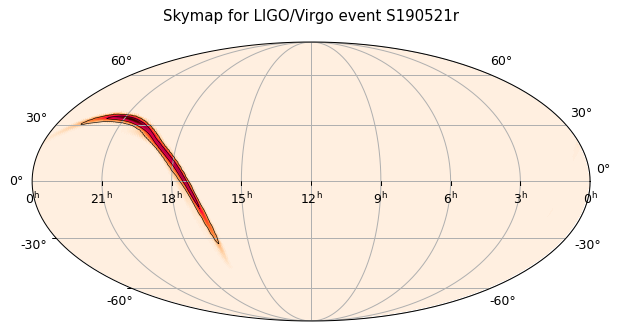

In [5]:
skymap.plot(title='Skymap for LIGO/Virgo event S190521r')


### Multi-order skymaps

The skymap we've been using is "flat", i.e. its pixels are at the same resolution across the entire sphere. That's incredibly inefficient for this sort of data, where an awful lot of the pixels away from the peak will essentially have a value of zero.

To better compress these sorts of skymaps there is an alternative HEALPix ordering method: `NUNIQ`, which produces a multi-order coverage (MOC) map. GOTO-tile can also read these maps, so let's load the multi-order map for the same map.

In [6]:
url_moc = 'https://gracedb.ligo.org/api/superevents/S190521r/files/GW190521_074359_PublicationSamples.multiorder.fits'
skymap_moc = SkyMap.from_fits(url_moc)


Here the number of pixels has been greatly reduced, because instead of the same resolution across the sphere different pixels now have different areas.

In [7]:
print('Npix:', skymap_moc.npix)


Npix: 16896


We can see the changing resolutions by plotting the pixels. Insread of using `SkyMap.plot()`, we can create our own axes and use the more flexible and granular `SkyMap.plot_data()` and `plot_pixels()` functions (there's also `plot_contours()` which we'll use later).

**Warning: this plot can take a while to generate.**

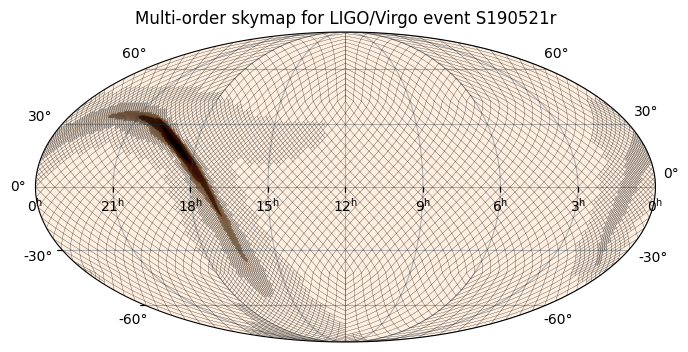

In [8]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(projection='astro hours mollweide')
axes.grid()

skymap_moc.plot_data(axes)
skymap_moc.plot_pixels(axes)

axes.set_title('Multi-order skymap for LIGO/Virgo event S190521r')

plt.show()


It's clear that the regions of high probability have a higher pixel resolution while the low-probability areas do not need the same number of pixels

We can also zoom in on the peak of the probability to see the different resolutions. To do this we find the index of the pixel at the peak of the distribution, then centre on those coordinates.

**Warning: this plot can take a while to generate.**

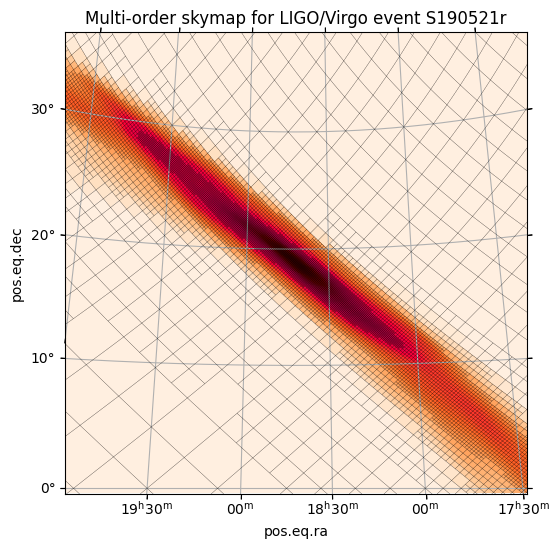

In [9]:
import numpy as np
max_coords = skymap_moc.coords[np.argmax(skymap_moc.data)]

fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(projection='astro zoom', center=max_coords, radius='20 deg')
axes.grid()

skymap_moc.plot_data(axes)
skymap_moc.plot_pixels(axes)

axes.set_title('Multi-order skymap for LIGO/Virgo event S190521r')

plt.show()


It's also worth mentioning that the skymap data is now given in units of probability density (probability per steradian) instead of just probability. You can convert between the two easily, if for instance you want to find the total probability within a given area (which we do when applying the skymap to a grid, see below).

Note how after converting the copy now sums to unity (well, almost), which is what you'd expect of a probability map.

In [10]:
print('Is this a density map?', skymap_moc.density)
print('Pixel sum:', sum(skymap_moc.data))

skymap_moc_copy = skymap_moc.copy()
skymap_moc_copy.density = False

print('Is this a density map?', skymap_moc_copy.density)
print('Pixel sum:', sum(skymap_moc_copy.data))


Is this a density map? True
Pixel sum: 102613.9859647357
Is this a density map? False
Pixel sum: 0.9999999999999962


---
## The SkyGrid class

The `gototile.grid` module contains the `SkyGrid` class, which can be used to create a regular grid of tiles in the sky for survey telescopes (such as GOTO).

In [11]:
from gototile.grid import SkyGrid


The `SkyGrid` class takes two parameters: the field of view of a tile (in RA and Dec) and the desired overlap between tiles in both axes (as a fraction: 0 is no overlap, 0.5 is overlapping half of each tile). Here we will use the parameters used by the GOTO-4 prototype: a tile of 3.7x4.9 degrees, with 10 % overlap in both axes.

In [12]:
grid = SkyGrid((3.7, 4.9), (0.1, 0.1))
grid


SkyGrid(fov=(3.7, 4.9), overlap=(0.1, 0.1), kind=minverlap)

Alternatively, since the package was created for GOTO several named grids are also pre-defined. This saves having to remember the above numbers every time. The basic 'GOTO' grid gives the final 8-UT grid, which we'll use from now on.

In [13]:
grid = SkyGrid.from_name('GOTO')
grid


SkyGrid(fov=(8.0, 5.5), overlap=(0.025, 0.03636363636363637), kind=enhanced1011)

Don't worry about the "kind" parameter here, it's related to the particular gridding function used to generate the array of tiles. See `gototile.gridtools` for more grid functions.

Useful properties include the number of tiles, the central coordinates of each (as a 1-D Astropy `SkyCoord`) and the tile name given to each (a 1-indexed string in the form `T1234`). Note that tiles are numbered in increasing Dec and RA, so tile `T0001` closest to the south pole.

In [14]:
print('Ntiles:', grid.ntiles)
for name, coord in zip(grid.tilenames, grid.coords):
    print(name, coord.to_string('hmsdms'))
    if name == 'T0015':
        # Stop after the first 15 tiles
        print('...')
        break


Ntiles: 1048
T0001 00h00m00s -87d21m00s
T0002 04h48m00s -87d21m00s
T0003 09h36m00s -87d21m00s
T0004 14h24m00s -87d21m00s
T0005 19h12m00s -87d21m00s
T0006 00h00m00s -82d03m21.81818182s
T0007 02h40m00s -82d03m21.81818182s
T0008 05h20m00s -82d03m21.81818182s
T0009 08h00m00s -82d03m21.81818182s
T0010 10h40m00s -82d03m21.81818182s
T0011 13h20m00s -82d03m21.81818182s
T0012 16h00m00s -82d03m21.81818182s
T0013 18h40m00s -82d03m21.81818182s
T0014 21h20m00s -82d03m21.81818182s
T0015 00h00m00s -76d45m43.63636364s
...


---
## Applying SkyMaps to SkyGrids

The real power of the above two classes arises when they are used together. "Applying" a probability skymap to a grid involves calculating the contained probability within each grid tile, and is easily done using the `SkyGrid.apply_skymap()` method:

In [15]:
grid.apply_skymap(skymap)


array([6.30174138e-05, 3.18255403e-05, 6.99278022e-06, ...,
       9.06892007e-44, 5.17788340e-45, 1.51998807e-47])

The above function returned the probability contained within each grid tile, this is also saved as `SkyMap.probs`. An easy way to find which tiles contain the most probability is to use the `SkyMap.get_table()` method, which returns an Astropy QTable.

In [16]:
table = grid.get_table()
table.sort('prob')
table.reverse()
table


tilename,ra,dec,prob
,deg,deg,
str5,float64,float64,float64
T0825,313.8461538461538,34.41060606060613,0.08846264511700051
T0784,298.5365853658537,29.11666666666673,0.08808246321322671
T0826,323.07692307692304,34.41060606060613,0.06500053206862626
T0652,272.0,13.234848484848541,0.06471756519163785
T0512,260.4255319148936,-2.6469696969696486,0.06220010167739407
T0606,266.0869565217391,7.940909090909145,0.06139725874994357
T0697,278.1818181818182,18.528787878787938,0.05895360820776871
T0824,304.6153846153846,34.41060606060613,0.055180277697053096


Note that since there will always be some overlap between tiles the total probability will sum to more than one (as we are double-counting any probability contained within multiple tiles).

In [17]:
print(f'Total probability in all tiles: {sum(grid.probs):.1%}')


Total probability in all tiles: 113.0%


As you can see from the table, tile `T0825` has the highest contained probability. Here you can get more details about that tile:

In [18]:
high_tile = np.argmax(grid.probs)
high_tile_name = grid.tilenames[high_tile]
high_tile_prob = grid.probs[high_tile]
high_tile_coord = grid.coords[high_tile]

print(f'The highest probability tile is {high_tile_name}.')
print(f'It contains {high_tile_prob:.2%} of the probability.')
print(f'It is centred on {high_tile_coord.to_string("hmsdms", precision=0)}.')


The highest probability tile is T0825.
It contains 8.85% of the probability.
It is centred on 20h55m23s +34d24m38s.


This tile contains the highest probability, but has a reasonable overlap with the neighboring tiles. The probability within their combined area will be less than the sum of both probabilities. This is where the `SkyGrid.get_probability()` method is useful, as it will only count for any HEALPix pixels contained within the combined area once.

In [19]:
tiles = ['T0824', 'T0825', 'T0826']
for tile in tiles:
    print(f'Probability within tile {tile}: {grid.get_probability(tile):.2%}')

prob_sum = sum([grid.get_probability(tile) for tile in tiles])
print(f'Probability sum (not accounting for overlap): {prob_sum:.3%}')

prob_sum = grid.get_probability(tiles)
print(f'Probability within total area (accounting for overlap): {prob_sum:.3%}')


Probability within tile T0824: 5.52%
Probability within tile T0825: 8.85%
Probability within tile T0826: 6.50%
Probability sum (not accounting for overlap): 20.864%
Probability within total area (accounting for overlap): 19.917%


The probability contained within each tile can also be plotted on the grid, which we can do using the `SkyGrid.plot_tiles()` function. Note we overlay the contours using `SkyMap.plot_contours()`.

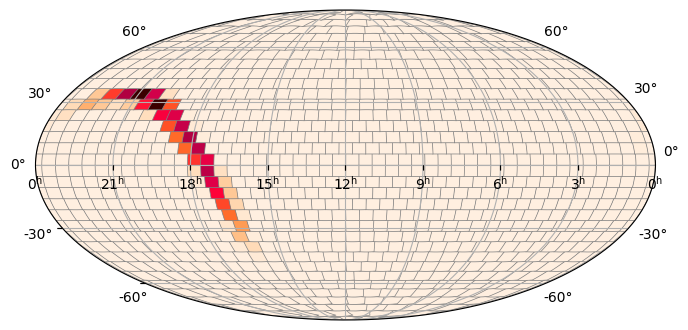

In [20]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(projection='astro hours mollweide')
axes.grid()

# Plot the tiles, with the data array given by the probability contained within each
# We also use the LIGO-preferred 'cylon' colormap
grid.plot_tiles(axes, array=grid.probs, cmap='cylon', ec='0.5')

plt.show()


For more examples of manipulating and plotting grids, see the [plot.ipynb](plot.ipynb) notebook.